# Counterfactual Transportability

This notebook is a demonstration of algorithms from Correa, Lee, and Bareinboim's 2022 paper, [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf).

In [1]:
import logging

from y0.algorithm.counterfactual_transportability import (
    transport_conditional_counterfactual_query,
    transport_unconditional_counterfactual_query,
)
from y0.algorithm.transport import transport_variable
from y0.dsl import (
    PP,
    TARGET_DOMAIN,
    X1,
    R,
    P,
    Pi1,
    Pi2,
    W,
    X,
    Y,
    Z,
    Variable,
)
from y0.graph import NxMixedGraph
from y0.algorithm.identify import identify_outcomes

In [2]:
logger=logging.getLogger()
logger.setLevel(logging.ERROR)
#logger.setLevel(logging.INFO) # Uncomment to view some of the function calls happening under the hood

## Motivating example

Suppose in a study of vaccine efficacy we're interested in the effect of COVID vaccination (Pfizer, Moderna, AstraZeneca, or no vaccine) on the number of days that a person who gets COVID reports symptoms. We might imagine a graph like the following:



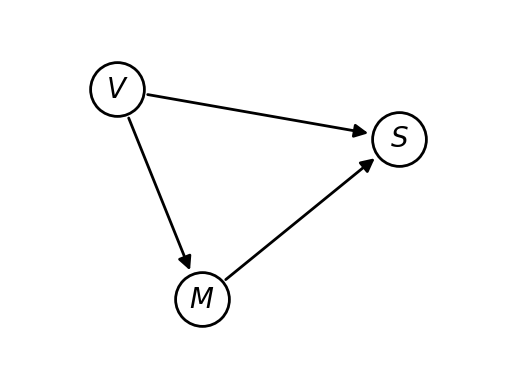

In [26]:
# Declare some variables first
USA = Variable(r"{USA}")
Australia = Variable(r"{AUS}")
Vaccine = Variable("V")
Mask = Variable("M")
Symptoms = Variable("S")

simple_education_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccine, Mask),
        (Mask, Symptoms),
        (Vaccine, Symptoms),
    ],
    undirected=[],
)
simple_education_graph.draw()

For purposes of simplicy, X represents vaccine type (e.g., Pfizer, Moderna, AstraZeneca, or no vaccine), Z represents the type of indoor mask worn during the two weeks prior to a COVID infection (surgical mask, N95 mask, or no mask), and Y represents the number of days of observed COVID-19 symptoms after infection. The vaccine type affects symptom duration directly because different vaccines have different efficacy rates, but vaccination can also affect masking behavior by increasing a person's risk tolerance, and masking may affect a person's COVID symptoms by adjusting the amount of initial viral load they experience during an infection. Thanks to an implementation of Shpitser's ID algorithm in Y0 by Nathaniel Merrill, we can estimate the total effect of the vaccine on symptom duration:

In [4]:
identify_outcomes(simple_education_graph, treatments={Vaccine}, outcomes={Symptoms})

Sum[M](P(M | V) * P(S | M, V))

This model is of course too simplistic, because many factors affect both the vaccine type and masking preferences such as medical history, social network effects, and so on. Let's represent those factors, "confounders", by a bi-directed edge between Vaccine and Mask:

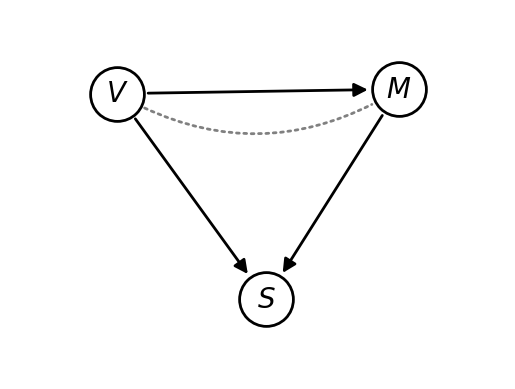

In [42]:
figure_1_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccine, Mask),
        (Mask, Symptoms),
        (Vaccine, Symptoms),
    ],
    undirected=[(Mask, Vaccine)],
)
figure_1_graph.draw()

The effect of vaccination type on symptom duration is not identifiable due to the confounders:

In [6]:
identify_outcomes(figure_1_graph, treatments={Vaccine}, outcomes={Symptoms})is None

True

The good news is that often we can determine a causal effect when a model is not identifiable by using experimental data from another setting, or by conditioning on additional variables. Let's see two examples in action!

## Conditional transportability example: vaccination and symptom duration

Suppose we want to know the effect of the type of vaccine $x$ on a person's symptom duration, were they forced to receive vaccine $x$ instead of the vaccine they preferred, $x'$. That would be represented in `Y0`as follows:

In [7]:
target = PP[USA](Symptoms@-Vaccine | Mask@-Vaccine, +Vaccine)
display(target)

P(S @ -V | M @ -V, +V)

Next, let's consider that we have two populations: an observational study in the United States, and a vaccine efficacy study in Australia in which people were randomly assigned to vaccine types and the effect on symptom duration was observed. Moreover, suppose the distribution of symptom duration in Australia is different than in the United States for unknown reasons.

In [8]:
# [correa22a]_, Figure 1, without the transportability node.
# (This graph represents the target domain, the United States.)
figure_1_graph_no_transportability_nodes = NxMixedGraph.from_edges(
    directed=[
        (Vaccine, Mask),
        (Mask, Symptoms),
        (Vaccine, Symptoms),
    ],
    undirected=[(Mask, Vaccine)],
)

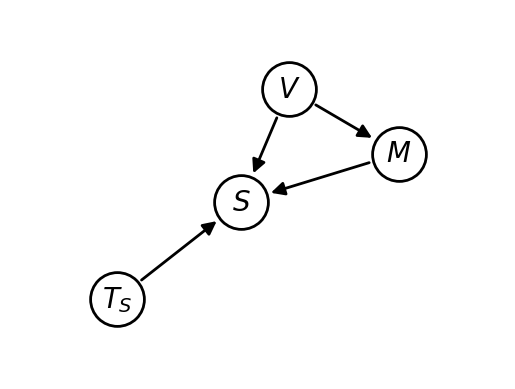

In [44]:
# Here is Australia.
figure_1_graph_domain_1_with_interventions = NxMixedGraph.from_edges(
    directed=[(Vaccine, Mask), (Vaccine, Symptoms), (Mask,Symptoms), (transport_variable(Symptoms), Symptoms)],
    undirected=[],
)
figure_1_graph_domain_1_with_interventions.draw()

The transportability node in the graph is there to remind us that the difference in the populations prohibits us from directly running the Identify algorithm on the graph for the Australian population to estimate the effect of vaccine type on symptom duration for the American sample.

We can estimate the effect using the conditional counterfactual transportability algorithm in `Y0`:

In [10]:
example_1_outcomes = [(Symptoms @ -Vaccine, -Symptoms)]
example_1_conditions = [(Mask @ -Vaccine, -Mask), (Vaccine, +Vaccine)]
example_1_target_domain_graph = figure_1_graph_no_transportability_nodes

figure_1_graph_no_transportability_nodes_topo = list(
    figure_1_graph_no_transportability_nodes.topological_sort()
) # Topologically sorted list of the vertices in the United States graph
figure_1_graph_domain_1_with_interventions_topo = list(
    figure_1_graph_domain_1_with_interventions.topological_sort()
) # Topologically sorted list of the vertices in the Australia graph
example_1_domain_graphs = [
    (
        figure_1_graph_no_transportability_nodes,
        figure_1_graph_no_transportability_nodes_topo,
    ), # United States
    (
        figure_1_graph_domain_1_with_interventions,
        figure_1_graph_domain_1_with_interventions_topo,
    ), # Australia
]
domain_data = [(set(), PP[USA](Vaccine, Symptoms, Mask)), 
               ({Vaccine}, PP[Australia](Vaccine, Symptoms, Mask))]

result_expr, result_event = transport_conditional_counterfactual_query(
    outcomes=example_1_outcomes,
    conditions=example_1_conditions,
    target_domain_graph=example_1_target_domain_graph,
    domain_graphs=example_1_domain_graphs,
    domain_data=domain_data,
)
print(str(result_event))
display(result_expr)

[(S, -S), (M, -M), (V, +V)]


((P(S | M, V) / Sum[S](P(S | M, V))))

For this example, it turns out that we can just compute the probability of symptom duration given vaccine type and masking preference for the United States, and we don't actually need the Australian data. That can happen. Note that Correa, Lee, and Bareinboim have an algorithm for _conditional transportability_ and an algorithm for _unconditional transportability_. Example 1 is in their paper to demonstrate that in some cases, conditional transportability works when unconditional transportability does not:

In [11]:
event=[(Symptoms @ -Vaccine, -Symptoms), (Mask @ -Vaccine, -Mask), (Vaccine, +Vaccine)]
transport_unconditional_counterfactual_query(
    event=event,
    target_domain_graph=example_1_target_domain_graph,
    domain_graphs=example_1_domain_graphs,
    domain_data=domain_data,
)==None

True

The reason turns out to be that $M_{v}$ and $v'$ are in the same c-component (they're connected by bi-directed edges). The problem is that we're considering the value of $M$ in a world where $V$ has been forced to be $v$, while simultaneously considering $V$ having a value of $v'$. Because $M$ and $V$ are connected by a path consisting of bi-directed edges, to transport the unconditional query $P(S_v, M_v, v')$ we would have to be able to identify the probabilistic expression associated with the c-component ${V,M}$, but cannot because of the inconsistent values of $V$.

## Unconditional transportability example: anti-retroviral therapy (ART) and AIDS mortality

Suppose we're interested in the effect of HIV anti-retroviral therapy ($T$) on mortality from AIDS ($A$) in a country in sub-Saharan Africa, in a model where the distance to the nearest clinic ($D$) affects mortality and selection into the type of ARV regimen, while also being confounded with the ARV treatment (e.g., personal income could affect the affordability of ARVs and the mode of transportation a person uses to access the clinic). Additionally, the ARV treatment affects a person's CD4 count ($C$), which affects mortality from AIDS and is also confounded with mortality, as comorbidity with other diseases could affect both the CD4 count and AIDS-related mortality. Here's the graph:

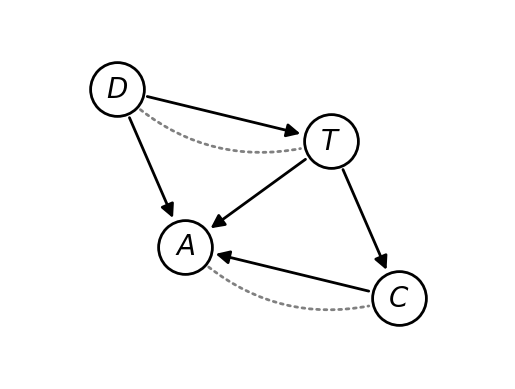

In [48]:
# Declare variables
Therapy = Variable("T")
Distance = Variable("D")
CD4 = Variable("C")
AIDS = Variable("A")

figure_2a_graph = NxMixedGraph.from_edges(
    directed=[
        (Distance, Therapy),
        (Distance, AIDS),
        (Therapy, AIDS),
        (Therapy, CD4),
        (CD4, AIDS),
    ],
    undirected=[(Distance, Therapy), (CD4, AIDS)],
)
figure_2a_graph.draw()

Earlier in the AIDS epidemic, rumors existed in some parts of Africa that ARVs and not the HIV virus were responsible for causing AIDS, and that raised concerns at the time that some people may not take ARVs even were they made available. Assuming that a program to provide ARVs to the public would only work if people are willing to take the drugs, suppose we want to know what receiving ARVs ($t_0$) does to AIDS-related mortality in a target population $\pi^\ast$, but specifically for people who choose to receive generic ARVs. So, we care about the difference in mortality for a person who chooses to take ARVs, compared to those for a person required to take them. Thus, we wish to know $E[A_{t_0} | t_0] - E[A_t | t_0]$. The first quantity is $E[A | t_0] = E[A, t_0] / E[t_0]$, and the second is $E[A_t | t_0] = E[A_t, t_0] / E[t_0]$. Let's estimate $E[A_t, t_0]$ using `transport_unconditional_counterfactual_query()`, introducing our data sets first.

### Data

Here we imagine we have a study in a different country than the target country in which ARVs were delivered to participants' villages directly, removing the bi-directed edge between $D$ and $T$ (Domain 1). But the population, $\pi^1$, has a different distribution of distance to the nearest clinic than our population of interest:


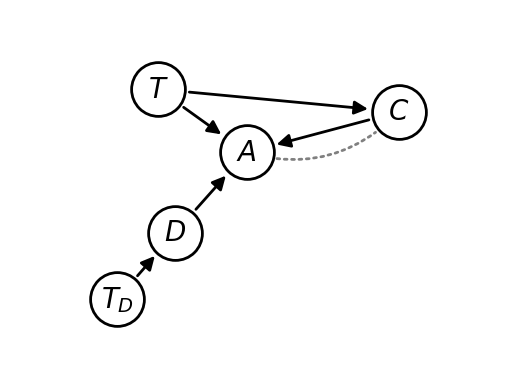

In [49]:
figure_2_graph_domain_1_with_interventions = NxMixedGraph.from_edges(
    directed=[(Therapy, AIDS), (Therapy, CD4), (CD4, AIDS), (Distance, AIDS), (transport_variable(Distance), Distance)],
    undirected=[
        (CD4, AIDS),
    ],
)
figure_2_graph_domain_1_with_interventions_topo = list(
    figure_2_graph_domain_1_with_interventions.topological_sort()
)
figure_2_graph_domain_1_with_interventions.draw()

The second set of data is an observational study in a high-risk population of injecting drug users, $\pi^2$, for which the overall CD4 count distribution is also different than the target population $\pi^{\ast}$ but the distribution of distances to the nearest clinic is the same:

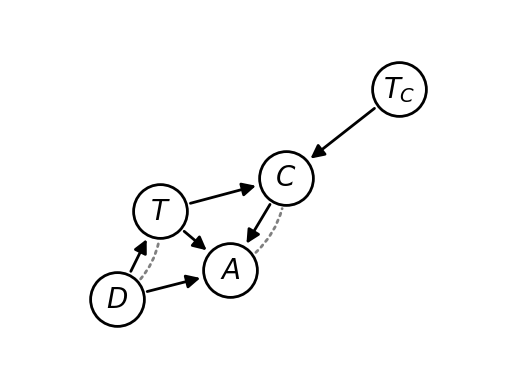

In [50]:
# From [correa22a]_, Figure 3b.
figure_2_graph_domain_2 = NxMixedGraph.from_edges(
    directed=[
        (Distance, Therapy),
        (Distance, AIDS),
        (Therapy, AIDS),
        (Therapy, CD4),
        (CD4, AIDS),
        (transport_variable(CD4), CD4),
    ],
    undirected=[(Distance, Therapy), (CD4, AIDS)],
)
figure_2_graph_domain_2_topo = list(figure_2_graph_domain_2.topological_sort())
figure_2_graph_domain_2.draw()

Let's estimate $E[A_t, t_0]$:

In [15]:
example_2_event = [(AIDS @ -Therapy, -AIDS), (Therapy, +Therapy)]
example_2_domain_graphs = [
    (
        figure_2_graph_domain_1_with_interventions,
        figure_2_graph_domain_1_with_interventions_topo,
    ),
    (
        figure_2_graph_domain_2,
        figure_2_graph_domain_2_topo,
    ),
]
example_2_domain_data = [({Therapy}, PP[Pi1](CD4, Therapy, AIDS, Distance)), (set(), PP[Pi2](CD4, Therapy, AIDS, Distance))]

example_2_result_expr, example_2_result_event = transport_unconditional_counterfactual_query(
    event=example_2_event,
    target_domain_graph=figure_2a_graph,
    domain_graphs=example_2_domain_graphs,
    domain_data=example_2_domain_data,
)

In [16]:
print(str(example_2_result_event))
display(example_2_result_expr)

[(A @ -T, -A), (T, +T)]


Sum[C, D](P(A | T, D, C) * P(C | T) * P(D) * P(T | D))

Here we can see the results from the two domain populations getting combined to resolve a causal query for the target population! That result matches Equation 4 in Correa, Lee, and Bareinboim net of some simplification. Next, here's $E[A, t0]$:

In [17]:
example_2_event_2 = [(AIDS, -AIDS), (Therapy, +Therapy)]
example_2_result_expr_2, example_2_result_event_2 = transport_unconditional_counterfactual_query(
    event=example_2_event_2,
    target_domain_graph=figure_2a_graph,
    domain_graphs=example_2_domain_graphs,
    domain_data=example_2_domain_data,
)

In [18]:
print(str(example_2_result_event_2))
display(example_2_result_expr_2)

[(A, -A), (T, +T)]


Sum[C, D](P(A | T, D, C) * P(C | T) * P(D) * P(T | D))

Compare this result to Equation 5 in Correa, Lee, and Bareinboim. Combining these two results, we can estimate our causal effect of interest.

It's worth noting we can also use `transport_conditional_counterfactual_query()` to estimate $P(A_t | t_0)$. The result is messier, but simplifying it and multiplying by $P(t_0)$ gives us the unconditional query result:

In [19]:
result_expr, result_event = transport_conditional_counterfactual_query(
    outcomes=[(AIDS@-Therapy,-AIDS)],
    conditions=[(Therapy,+Therapy)],
    target_domain_graph=figure_2a_graph,
    domain_graphs=example_2_domain_graphs,
    domain_data=example_2_domain_data,
)

In [20]:
print(str(result_event))
display(result_expr)

[(A, -A), (T, +T)]


((Sum[C, D](P(A | T, D, C) * P(C | T) * P(D) * P(T | D)) / Sum[A, C, D](P(A | T, D, C) * P(C | T) * P(D) * P(T | D))))

## User interface demonstration

The following exercise is from a tutorial at Pacific Northwest National Laboratory that demonstrates that detailed validation of user inputs makes using the software easy. We've deliberately included some typos in the problem solution and show the software catching them. Feel free to experiment with the input parameters and generate other errors!

1. Construct a graph with the following edges:
X1 -> Z,
R -> Z,
Z -> W,
W -> Y,
W <-> Z

2. Consider you have available observational data from the target domain, and an experiment from Domain 1 in which W is fixed to be only a function of Z (breaking the bidirected edge between W and Z), and R is drawn from a different population than in the target domain.

3. Estimate $P(Y_{X1},W_{R}|X1)$ with the values ${-Y,-W,-X}$ respectively.

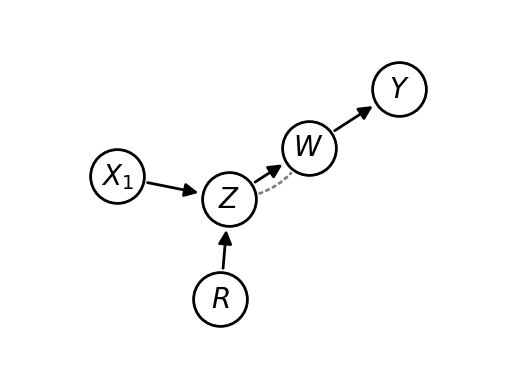

In [52]:
example_3_target_domain_graph = NxMixedGraph.from_edges(
    directed=[
        (X1, Z),
        (R, Z),
        (Z, W),
        (W, Y),
    ],
    undirected=[(Z, W)],
)
example_3_target_domain_graph.draw()

In [22]:
example_3_break_w_graph = NxMixedGraph.from_edges(
    directed=[
        (X1, Z),
        (R, Z),
        (Z, W),
        (W, Y),
        (transport_variable(R), R),
    ],
    undirected=[],
)
#example_3_break_w_graph.draw()

In [53]:
example_3_outcomes = [(Y @ -X1, -Y), (W @ -R, -W)]
example_3_conditions = [(X, -X)] ## NOTE: Should be X1

example_3_target_domain_graph_topo = list(
    example_3_target_domain_graph.topological_sort()
) 
example_3_break_w_graph_topo = list(
    example_3_break_w_graph.topological_sort()
) 
example_3_domain_graphs = [
    (
        example_3_break_w_graph,
        example_3_break_w_graph_topo,
    ),
    (
        example_3_target_domain_graph,
        [W,X1,R,Z,Y],#example_3_target_domain_graph_topo,  ## NOTE: These vertices are not in an appropriate topological order
    ), 
]
domain_data = [({W}, PP[Pi1](X1, R, W, Y, Z)),
               (set(), PP[TARGET_DOMAIN](X1, R, W, Y, Z))]
result_expr, result_event = transport_conditional_counterfactual_query(
    outcomes=example_3_outcomes,
    conditions=example_3_conditions,
    target_domain_graph=example_3_target_domain_graph,
    domain_graphs=example_3_domain_graphs,
    domain_data=domain_data,
)
print(str(result_event))
display(result_expr)

ValueError: In _validate_transport_conditional_counterfactual_query_input: one of the input conditioned variables is not in the target domain graph. Check your inputs. 